# Protecting AI Asset

## Data Protection at Rest with Disk Encryption using Trusted Platform Module (TPM)
Disk encryption protects storage devices from attacker with intention to dump sensitive information by mounting the storage device on alternative operating environments under attacker control. 




### Process flow for today's activity are as below:

1. Run AI Asset demo
2. Create an unencrypted disk to store AI Asset
3. Use a simple disk method to store AI Asset
4. Disk encryption with passphrase store in TPM
5. Enchance TPM encryption with Platform Configuration Register (PCR) policy

### Prerequisites

#### Download OpenVINO™ as an AI Asset references

1. Download the Intel's pretrained Alexnet model. In this example, you will be using the OpenVINO™ toolkit Intermediate Representation (.xml + .bin).
   Refer to OpenVINO™ documentation. https://docs.openvino.ai/archive/2023.2/omz_models_model_alexnet.html#doxid-omz-models-model-alexnet
2. Download OpenVINO™ reference image from here: https://storage.openvinotoolkit.org/data/test_data/images/banana.jpg

#### TPM Verification

1. Hardware verification - Verify in BIOS setting

2. Software verification - Verify in kernel and systemd-logging

    a. Verify supported TPM version in kernel:

In [ ]:
!cat /sys/class/tpm/tpm0/device/tpm/tpm0/tpm_version_major

#### Software Dependencies Installation

tpm2-tools is part of the community supported tpm2-software project on github. It is an implementation of the trusted software stack specification by TCG.
cryptsetup is a CLI to interface with dm-crypt for creating, accessing, manageing and encrypted devices. 

Download the software tools below:

    a. tpm2-tools installation:

In [ ]:
!apt-get install --assume-yes tpm2-tools tpm2-abrmd

    b. cryptsetup installation:

In [ ]:
!export DEBIAN_FRONTEND=noninteractive
!apt-get install --assume-yes cryptsetup

### Let's Get Started 

#### Step 1: Run AI Asset using OpenVINO™

In this chapter, the AI Asset is predownloaded and its usage is only for this demo. 
It is to show how you can store your AI Asset at rest. 

Run the AI model demo.

In [ ]:
!python3 /opt/intel/openvino/samples/python/hello_classification/hello_classification.py alexnet.xml banana.jpg CPU

#### Step 2: Create an Unencrypted Disk to Store the AI Asset

In this chapter, you will start by creating a disk to store the AI Asset that you have run in Step 1.

1. Create a disk to store AI Asset.

In [ ]:
!fallocate -l 10GB CONTAINER

2. Create a mountpoint for the partition disk container and format it.

In [ ]:
!mkdir -p mountpoint
!mkfs.ext4 -j -F CONTAINER

#### Step 3: Use Simple Disk Encryption Method to Store AI Asset

In this chapter, you will learn on how to create and use disk encryption using LUKS.
Linux Unified Key Setup (LUKS) is a disk encryption specification for Linux. 

1. Create a disk.key using random number generator.

In [ ]:
!dd if=/dev/urandom of=disk.key bs=1 count=32

2. Set up a LUKS device.

In [ ]:
!cryptsetup -q -v luksFormat CONTAINER --key-file=disk.key

3. Decrypt the CONTAINER and format it.

In [ ]:
!cryptsetup -v luksOpen CONTAINER container --key-file=disk.key
!mkfs.ext4 -j /dev/mapper/container

4. Mount the container to copy the AI Asset from before.

In [ ]:
!mount /dev/mapper/container mountpoint/

5. Copy the AI Asset into the container.

In [ ]:
!cp alexnet.* mountpoint/

6. Unmount the container.

In [ ]:
!umount mountpoint

7. Encrypt the container.

In [ ]:
!cryptsetup luksClose container

8. Verify if the container is encrypted by using a passphrase or another key file.

In [ ]:
!echo "test" | cryptsetup luksOpen CONTAINER container -
!mount /dev/mapper/container mountpoint/

#### Step 4: Disk Encryption by Storing Key into TPM

In this activity you will learn how to seal secret into a TPM device, unseal the secret in the memory and pass it to the cryptsetup. This way, we are using TPM as a protector of the secrets.
Before we start, you need to make sure the TPM persistent handles. A handle is a 32-bit reference to TPM entity. It uniquely identifies a TPM resources that occupies TPM memory.



There are 3 types of handles. 

| TPM Handles | Description |
| --- | --- |
| Transient | Addresses of keys in the NVRAM. Points to the key that can be loaded into TPM or recreated |
| Persistent | Reference memory keys in TPM. Persisted through power cycle and can be recreated upon requirement |
| Permanent | Reference entities that cannot be deleted |

1. Verify TPM persistent memory. In this step, you are checking which TPM memory is in persistent status.

In [ ]:
!tpm2_getcap handles-persistent

2. For educational purpose, you will be using 0x81010001. Evict the address.

In [ ]:
!tpm2_evictcontrol -C o -c 0x81010001

3. Create a persistent sealing object and seal a random byte sequence as a disk key.

In [ ]:
!tpm2_createprimary -Q --hierarchy=o --key-context=prim.ctx
!dd if=/dev/urandom bs=1 count=32 status=none | tpm2_create --hash-algorithm=sha256 --public=seal.pub --private=seal.priv --sealing-input=- --parent-context=prim.ctx
!tpm2_load -Q --parent-context=prim.ctx --public=seal.pub --private=seal.priv --name=seal.name --key-context=seal.ctx

4. Save it to the TPM persistent memory.

In [ ]:
!tpm2_evictcontrol --hierarchy=o --object-context=seal.ctx 0x81010001

5. Change the authentication from the disk.key to a new sealed secret.

In [ ]:
!tpm2_unseal -Q --object-context=0x81010001 | cryptsetup luksChangeKey CONTAINER --key-file=disk.key 

In here, we are changing the the authentication from disk.key to the secret that we created stored in TPM. In ideal case, you can shred your keys since its no longer useful. For the purpose of learning, we will keep the disk.key and use it for a later steps. 

6. Verify if the encrypted container can be opened using a new key.

In [ ]:
!tpm2_unseal -Q -c 0x81010001 | cryptsetup luksOpen CONTAINER container --key-file=-

7. Mount the decrypted disk to verify if your asset is still available.

In [ ]:
!mount /dev/mapper/container mountpoint/
!python3 /opt/intel/openvino/samples/python/hello_classification/hello_classification.py mountpoint/alexnet.xml banana.jpg CPU

8. Unmount the decrypted disk to prepare to seal it back

In [ ]:
!umount mountpoint

8. Close the container.

In [ ]:
!cryptsetup luksClose container

From this activity, attacker will now need TPM alongside with the disk since the decryption key is safely stored in TPM.

### Step 5: Enhance TPM2 Encryption with PCR Policy Authentication

We can further enhance asset security by implementing a passphrase to the sealing object. However, we will need to store it on the file-system. Since TPM cannot tell apart who is presenting the authentication and access can simply be granted, which makes it vulnerable. In this scenario, imagine an attacker is now on the same system, boot to an alternative OS which the credentials are fully controlled by the attacker. So sealing an object without an authentication is useless if we are keeping the secret to the system. 
In this section you will learn on how to use PCR as an authentication. Then, after the unsealing is completed, extend the sealing PCR so that the secret cannot be unsealed again.

> PCR is Platform Configuration Registers. Their role is to store integrity measurements of the code (software state) running on the system. Usually TPM have at least 1 PCR bank with 24 registers, each registers stores 20 byte of data. Some TPM devices have 2 PCR bank.

1. Creating a PCR policy with current value in PCR0 sha256 bank.

In [ ]:
!tpm2_startauthsession --session=session.ctx
!tpm2_policypcr -Q --session=session.ctx --pcr-list="sha256:0" --policy=pcr0.sha256.policy
!tpm2_flushcontext session.ctx

2. Replace seal object in TPM NV memory protecting the disk encryption secret with new one that adds to the PCR policy that we have created. This acts as an authentication mechanism to access sealed secret.

In [ ]:
!tpm2_unseal --object-context=0x81010001 | tpm2_create -Q --hash-algorithm=sha256 --public=pcr_seal_key.pub --private=pcr_seal_key.priv --sealing-input=- --parent-context=prim.ctx --policy=pcr0.sha256.policy
!tpm2_evictcontrol --hierarchy=o --object-context=0x81010001
!tpm2_load -Q --parent-context=prim.ctx --public=pcr_seal_key.pub --private=pcr_seal_key.priv --name=pcr_seal_key.name --key-context=pcr_seal_key.ctx
!tpm2_evictcontrol --hierarchy=o --object-context=pcr_seal_key.ctx 0x81010001

3. Mount the encrypted disk with the secret unsealed off a TPM object. The unsealing operation can only be accessed by satisfying the PCR policy.

In [ ]:
!tpm2_startauthsession --policy-session --session=session.ctx
!tpm2_policypcr -Q --session=session.ctx --pcr-list="sha256:0" --policy=pcr0.sha256.policy

4. Make a copy of the unsealed secret at this point to seal it with a new object with flexible PCR policy.

In [ ]:
!tpm2_unseal -p session:session.ctx -c 0x81010001 > disk_secret.bkup
!cat disk_secret.bkup | cryptsetup luksOpen CONTAINER container --key-file=-
!tpm2_flushcontext session.ctx

5. Simulating PCR value changes due to the software changes. 

In [ ]:
!tpm2_pcrread sha256:0
!tpm2_pcrextend 0:sha256=0000000000000000000000000000000000000000000000000000000000000000
!tpm2_pcrread sha256:0

6. Unseal the disk with dirty PCR.

In [ ]:
!tpm2_startauthsession --policy-session --session=session.ctx
!tpm2_policypcr -Q -S session.ctx -l sha256:0

7. Verify the policy check failure that prevent the unseal operation.

In [ ]:
!tpm2_unseal --auth=session:session.ctx --object-context=0x81010001
!tpm2_flushcontext session.ctx

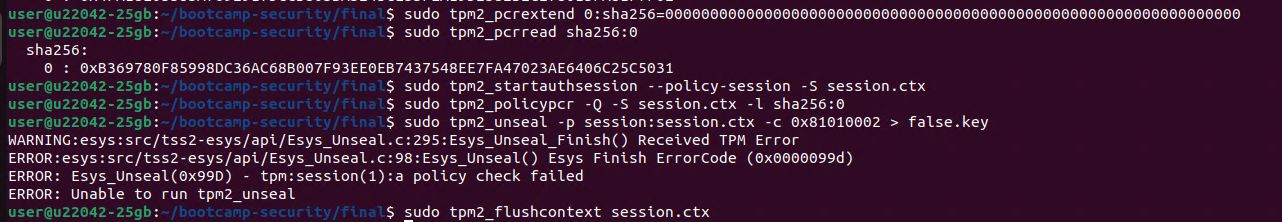

8. Close the container.

In [ ]:
!cryptsetup luksClose container

Software updates are important part of a good system design. Sealing secrets to the PCR reflecting on a software state, will break the security measure that we have done.
After software updates happened, the PCR value will change. For the TPM to release the sealed data, the active PCR state must match the one stated in the policy. That's a must.

If the active PCR state has changed, it will be the default for future boots. 
The secret must either be resealed to the new PCR state or the policy should allow for flexible PCR states.
Below are the steps to address the brittleness of PCR:                                                                                                               

9. Get the new set of PCR and sign the pcr policy with signer private key.

In [ ]:
!tpm2_startauthsession -S session.ctx
!tpm2_policypcr -Q -S session.ctx -l sha256:0 -L set2.pcr.policy
!tpm2_flushcontext session.ctx
!openssl genrsa -out signing_key_private.pem 2048
!openssl rsa -in signing_key_private.pem -out signing_key_public.pem -pubout
!tpm2_loadexternal -G rsa -C o -u signing_key_public.pem -c signing_key.ctx -n signing_key.name

10. Create a signer policy.

In [ ]:
!tpm2_startauthsession -S session.ctx
!tpm2_policyauthorize -S session.ctx -L authorized.policy -n signing_key.name -i set2.pcr.policy
!tpm2_flushcontext session.ctx

11. Create new sealing object with the authorized policy.

In [ ]:
!cat disk_secret.bkup | tpm2_create -g sha256 -u auth_pcr_seal_key.pub -r auth_pcr_seal_key.priv -i- -C prim.ctx -L authorized.policy

12. Replace old persistent with the new authorized PCR policy with signer.

In [ ]:
!tpm2_evictcontrol -C o -c 0x81010001
!tpm2_load -Q -C prim.ctx -u auth_pcr_seal_key.pub -r auth_pcr_seal_key.priv -n auth_pcr_seal_key.name -c auth_pcr_seal_key.ctx
!tpm2_evictcontrol -c auth_pcr_seal_key.ctx 0x81010001 -C o
!openssl dgst -sha256 -sign signing_key_private.pem -out set2.pcr.signature set2.pcr.policy

13. Load the signer public key to the TPM and verify the signature on the PCR and get the TPM verification ticket.

In [ ]:
!tpm2_loadexternal -G rsa -C o -u signing_key_public.pem -c signing_key.ctx -n signing_key.name
!tpm2_verifysignature -c signing_key.ctx -g sha256 -m set2.pcr.policy -s set2.pcr.signature -t verification.tkt -f rsassa

14. Satisfy the authorized policy and run policy authorize.

In [ ]:
!tpm2_startauthsession --policy-session -S session.ctx
!tpm2_policypcr -l sha256:0 -S session.ctx
!tpm2_policyauthorize -S session.ctx -i set2.pcr.policy -n signing_key.name -t verification.tkt

15. Pipe unseal output to the cryptsetup application.

In [ ]:
!tpm2_unseal -p session:session.ctx -c 0x81010001 | cryptsetup luksOpen --key-file=- CONTAINER container
!tpm2_flushcontext session.ctx
!mount /dev/mapper/container mountpoint/
!ls mountpoint/

#### Summary

Intel® Platform Trust Technology (Intel® PTT) is a useful technology based on the TCG TPM 2.0 specifications. 
This can helps to enable protection to the AI Asset at rest using Intel PTT. It is used to protect the encryption key againsts offline attack.
This means that the attacker will need to have the hardware TPM alongside the encrypted disk to decrypt it.

#### Notices & Disclaimers

Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure.

Your costs and results may vary.

No license (express or implied, by estoppel or otherwise) to any intellectual property rights is granted by this document, with the sole exception that code included in this document is licensed subject to the Zero-Clause BSD open source license (0BSD), Open Source Initiative. No rights are granted to create modifications or derivatives of this document.

© Intel Corporation.  Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries.  Other names and brands may be claimed as the property of others.